In [1]:
import numpy as np
import torch, torch.nn as nn
import gymnasium as gym

In [2]:
gym.register(id='Dragonsweeper-v0', entry_point="Environment:DragonSweeperEnv")
device = torch.device("cpu")

In [3]:
env = gym.make("Dragonsweeper-v0", render_mode=None)

In [5]:
def flat_obs(obs, device=device):
    board = torch.tensor(obs['board'], dtype=torch.float32, device=device).flatten()
    player = torch.tensor(obs['player'], dtype=torch.float32, device=device).flatten()
    return torch.cat((board, player), dim=0)

In [6]:
obs_size = len(flat_obs(env.reset()[0])) # TODO: Remove this before end, yucky pointless reset
channel_size = 256
num_actions = env.action_space.n

In [7]:
num_actions

np.int64(131)

In [47]:
import copy
def rmove_tree(env):
    rewards = torch.zeros(env.action_space.n)
    tree_env = None
    for action in range(num_actions):
        tree_env = copy.deepcopy(env)
        rewards[action] += tree_env.step(action)[1]
    return rewards

In [52]:
pre_losses = []
pre_actions = []

In [60]:
for i in range(1000):
    logits = simp_net(flat_obs(obs))
    probs = nn.functional.softmax(logits, dim=0)
    probs = (1-eps) * probs + eps/num_actions
    
    naive_optimal = rmove_tree(env).argmax()
    action = torch.multinomial(probs, num_samples=1).item()
    
    loss = nn.functional.cross_entropy(probs, naive_optimal)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pre_losses.append(loss.item())
    
    action = naive_optimal.item()
    obs, reward, terminated, truncated, _  = env.step(action)
    if terminated or truncated:
        pre_actions.append(action)
        env.reset()

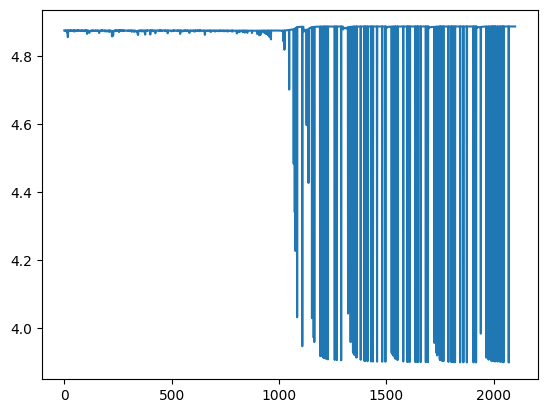

In [61]:
from matplotlib import pyplot as plt
plt.plot(pre_losses)

In [8]:
simp_net = torch.nn.Sequential(
    nn.Linear(obs_size, channel_size),
    nn.LayerNorm(channel_size, channel_size),
    nn.ReLU(),
    nn.Linear(channel_size, channel_size),
    nn.LayerNorm(channel_size, channel_size),
    nn.ReLU(),
    nn.Linear(channel_size, num_actions),
    nn.LayerNorm(num_actions, num_actions),
    nn.ReLU(),
)

In [62]:
optimizer = torch.optim.Adam(params=simp_net.parameters())

In [63]:
obs, _ = env.reset()

In [64]:
losses = []
actions = []

In [65]:
eps = 1e-2

In [85]:
for episode in range(10000):
    logits = simp_net(flat_obs(obs))
    probs = nn.functional.softmax(logits, dim=0)
    probs = (1-eps) * probs + eps/num_actions
    action = torch.multinomial(probs, num_samples=1).item()
    obs, reward, terminated, truncated, _ = env.step(action)
    loss = -(torch.log_softmax(logits, dim=0)[action]) * reward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if terminated or truncated:
        actions.append(action)
        obs, _ = env.reset()

In [86]:
sum(losses)/len(losses)

-1.394502124417568

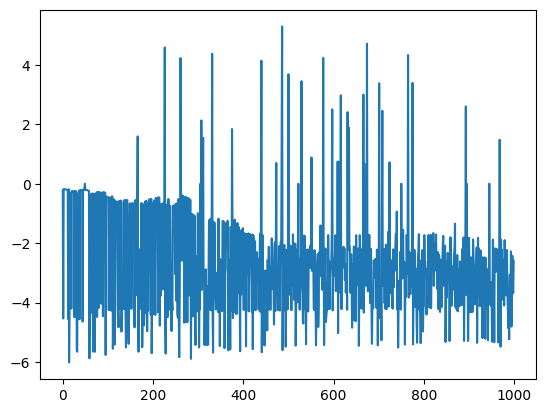

In [93]:
plt.plot(losses[0:1000])

In [90]:
sum(losses[0:100])/100

-1.3333782055974006

In [91]:
sum(losses[-100:])/100

-1.0473945531621576